In [1]:
import pandas as pd
import numpy as np
import queries as qy

In [2]:
import os
from configparser import ConfigParser

def get_config():
    config = ConfigParser()
    config.read(os.path.join("C:/Users/andres.mireles_ebury/Desktop/Projects/FX Exposure/Net Exposure/config.ini"))

    return config

from bq_link import get_bq_link
bq_client, _ = get_bq_link(get_config())

Load all the exposures

In [20]:
balance_date = "2024-04-30"
exposures_entities = bq_client.query(qy.net_exposure.format(date=balance_date)).drop_duplicates()

In [21]:
exposures_entities

,currency,entity,entity_ccy,above_exposure_gbp,above_exposure_local_ccy,above_exposure_entity_ccy,below_exposure_gbp,below_exposure_local_ccy,below_exposure_entity_ccy,net_exposure_gbp,net_exposure_local_ccy,net_exposure_entity_ccy
0,MUR,EPBE,EUR,-0.01,4.656613e-10,4.365575e-11,-2.454525e+01,-1424.07,-2.874487e+01,-2.455525e+01,-1424.07,-2.874487e+01
1,CNY,EPHK,HKD,0.00,0.000000e+00,-9.313226e-10,-4.370807e+05,-3959978.98,-4.277194e+06,-4.370807e+05,-3959978.98,-4.277194e+06
2,BRL,EPBE,EUR,26360.98,1.707233e+05,3.086067e+04,-1.417882e+04,-91858.74,-1.660477e+04,1.218216e+04,78864.58,1.425589e+04
3,BRL,EPL,GBP,0.00,0.000000e+00,0.000000e+00,-5.138683e+06,-33291415.01,-5.138683e+06,-5.138683e+06,-33291415.01,-5.138683e+06
4,NAD,EPUK,GBP,0.00,0.000000e+00,0.000000e+00,1.466950e+03,34531.37,1.466950e+03,1.466950e+03,34531.37,1.466950e+03
...,...,...,...,...,...,...,...,...,...,...,...,...
585,ISK,EPBE,EUR,0.00,0.000000e+00,0.000000e+00,-5.696395e-03,-1.00,-6.671031e-03,-5.696395e-03,-1.00,-6.671031e-03
586,PYG,EPBE,EUR,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00
587,MAD,EPCA,CAD,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00
588,HKD,EPCH,CHF,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00


Set the group threshold and the individual entity threshold (in the future, these can be weighted)

The total exposures by currency

In [22]:
total_exposures = exposures_entities.groupby("currency")[["above_exposure_gbp","above_exposure_local_ccy","below_exposure_gbp","below_exposure_local_ccy","net_exposure_gbp","net_exposure_local_ccy"]].sum()

Use only the entitiies with high exposures

In [23]:
group_threshold = 5e6

In [24]:
large_exposure_currencies = total_exposures[
    (np.abs(total_exposures.above_exposure_gbp)>=group_threshold)|
    (np.abs(total_exposures.below_exposure_gbp)>=group_threshold)|
    (np.abs(total_exposures.net_exposure_gbp)>=group_threshold)
].index

In [25]:
large_exposure_currencies

Index(['AED', 'AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'HKD', 'PLN', 'USD'], dtype='object', name='currency')

In [26]:
exposures_entities = exposures_entities[exposures_entities.currency.isin(large_exposure_currencies)]

In [27]:
exposures_entities

,currency,entity,entity_ccy,above_exposure_gbp,above_exposure_local_ccy,above_exposure_entity_ccy,below_exposure_gbp,below_exposure_local_ccy,below_exposure_entity_ccy,net_exposure_gbp,net_exposure_local_ccy,net_exposure_entity_ccy
9,GBP,EPUS,USD,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.00,0.000000e+00
11,AUD,EPUK,GBP,-25906514.80,-49951951.33,-2.590651e+07,1.365527e+07,26329561.10,1.365527e+07,-1.225125e+07,-23622390.23,-1.225125e+07
12,USD,EPDIFC,USD,1568991.20,1963121.84,1.963122e+06,6.091773e+05,762202.58,7.622026e+05,2.178168e+06,2725324.42,2.725324e+06
14,AUD,EPDIFC,USD,11241.42,21675.30,1.406528e+04,4.303254e+03,8297.37,5.384232e+03,1.554467e+04,29972.67,1.944951e+04
28,AUD,EPF,GBP,-0.01,0.00,-5.820766e-11,8.461003e+05,1631418.34,8.461003e+05,8.461003e+05,1631418.34,8.461003e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
566,CHF,EPCA,CAD,0.00,0.00,0.000000e+00,-1.979571e+02,-227.25,-3.405282e+02,-1.979571e+02,-227.25,-3.405282e+02
574,GBP,EPM-Cyprus,EUR,0.00,0.00,0.000000e+00,-4.295290e+03,-4295.29,-5.030201e+03,-4.295290e+03,-4295.29,-5.030201e+03
576,GBP,EPCA,CAD,2928.84,2928.84,5.038227e+03,-3.036626e+06,-3036626.46,-5.223642e+06,-3.033698e+06,-3033697.62,-5.218604e+06
577,AUD,EPCA,CAD,0.00,0.00,0.000000e+00,-8.204706e+00,-15.82,-1.411384e+01,-8.204706e+00,-15.82,-1.411384e+01


Only the entities with large exposures to each currency

In [28]:
entity_threshold = group_threshold / (2 * exposures_entities.entity.unique().shape[0])

In [29]:
exposures_entities = exposures_entities.set_index(["currency","entity","entity_ccy"])

In [32]:
large_exposure_entities_currencies = exposures_entities[
    (np.abs(exposures_entities.above_exposure_gbp)>=entity_threshold)|
    (np.abs(exposures_entities.below_exposure_gbp)>=entity_threshold)|
    (np.abs(exposures_entities.net_exposure_gbp)>=entity_threshold)
].index

In [35]:
exposures_entities = exposures_entities.loc[large_exposure_entities_currencies]

In [36]:
currency = "EUR"

exposures_entities = exposures_entities.loc[currency]

In [37]:
exposures_entities

,,above_exposure_gbp,above_exposure_local_ccy,above_exposure_entity_ccy,below_exposure_gbp,below_exposure_local_ccy,below_exposure_entity_ccy,net_exposure_gbp,net_exposure_local_ccy,net_exposure_entity_ccy
entity,entity_ccy,,,,,,,,,
EPCA,CAD,9.321314e+04,1.091617e+05,1.603465e+05,-8.011664e+05,-9.382435e+05,-1.378176e+06,-7.079532e+05,-8.290818e+05,-1.217830e+06
EPUK,GBP,-8.015238e+07,-9.386620e+07,-8.015238e+07,1.409674e+08,1.650864e+08,1.409674e+08,6.081498e+07,7.122023e+07,6.081498e+07
EPF,GBP,0.000000e+00,0.000000e+00,0.000000e+00,-2.054219e+06,-2.405690e+06,-2.054219e+06,-2.054219e+06,-2.405690e+06,-2.054219e+06
EPM,GBP,-1.231152e+04,-1.441805e+04,-1.231158e+04,1.516280e+06,1.775711e+06,1.516280e+06,1.503968e+06,1.761293e+06,1.503968e+06
EPL,GBP,0.000000e+00,0.000000e+00,0.000000e+00,-4.787437e+07,-5.606553e+07,-4.787437e+07,-4.787437e+07,-5.606553e+07,-4.787437e+07
EPBE,EUR,6.923909e+07,8.108567e+07,8.108567e+07,-6.897756e+07,-8.077941e+07,-8.077941e+07,2.615338e+05,3.062636e+05,3.062636e+05
ETL,GBP,0.000000e+00,0.000000e+00,0.000000e+00,-2.701334e+07,-3.163524e+07,-2.701334e+07,-2.701334e+07,-3.163524e+07,-2.701334e+07
EPM-Cyprus,EUR,0.000000e+00,0.000000e+00,0.000000e+00,-2.260228e+05,-2.646946e+05,-2.646946e+05,-2.260228e+05,-2.646946e+05,-2.646946e+05
EPHK,HKD,6.286978e+05,7.362662e+05,6.152326e+06,-7.764403e+05,-9.092869e+05,-7.598107e+06,-1.477425e+05,-1.730206e+05,-1.445780e+06


### 1) Hedge whatever we can of the Above/Below for each entity

In [39]:
def net_exposure(currency,entity,entity_ccy, above,above_local_ccy,above_entity_ccy,below,below_local_ccy,below_entity_ccy,threshold):

    if above == below == 0 or entity=="EPL" or currency == entity_ccy:
        return above, above_local_ccy, above_entity_ccy, below, below_local_ccy, below_entity_ccy, above+below, above_local_ccy+below_local_ccy, above_entity_ccy+below_entity_ccy, 0, 0, np.nan, np.nan, 0, 0, np.nan

    # Rate to convert gbp to local ccy
    if below != 0:
        rate_to_local_ccy = below_local_ccy / below
        rate_to_entity_ccy = below_entity_ccy / below
    else:
        rate_to_local_ccy = above_local_ccy / above
        rate_to_entity_ccy = above_entity_ccy / above


    # Signs of the below to move the exposure (if below is 0, then just the opposite of the sign of the above)
    if below != 0:
        sign_below = below / abs(below)
    else:
        sign_below = -1 * above / abs(above)

    # The internal change that we need
    internal_change = np.maximum(abs(below) - threshold,0)

    internal_change_local_ccy = internal_change * rate_to_local_ccy
    internal_change_entity_ccy = internal_change * rate_to_entity_ccy

    # The resulting exposures
    new_above = above + sign_below*internal_change
    new_above_local_ccy = above_local_ccy + sign_below*internal_change_local_ccy
    new_above_entity_ccy = above_entity_ccy + sign_below*internal_change_entity_ccy
    new_below = below - sign_below*internal_change
    new_below_local_ccy = below_local_ccy - sign_below*internal_change_local_ccy
    new_below_entity_ccy = below_entity_ccy - sign_below*internal_change_entity_ccy

    # The direction of the internal entity hedges
    below_lhs_rhs = np.where(
        internal_change != 0,
        np.where(sign_below>0,"LHS","RHS"),
        np.nan
    )
    above_lhs_rhs = np.where(
        internal_change != 0,
        np.where(sign_below>0,"RHS","LHS"),
        np.nan
    )

    # What we are going to move from the above of the entity to the above in EPL
    above_to_epl = np.maximum(abs(new_above) - threshold,0)

    above_to_epl_local_ccy = above_to_epl * rate_to_local_ccy
    above_to_epl_entity_ccy = above_to_epl * rate_to_entity_ccy

    
    # The direction of the above to EPL hedges (if above = 0, we don't move anything)
    above_to_epl_lhs_rhs = np.where(
        above_to_epl != 0,
        np.where(new_above/abs(new_above)>0,"LHS","RHS"),
        np.nan
    )

    # Update the new above of that entity reducing what we move to EPL
    new_above = new_above - np.where(
        new_above!=0,
        new_above/abs(new_above)*above_to_epl,
        0
    )
    new_above_local_ccy = new_above_local_ccy - np.where(
        new_above!=0,
        new_above_local_ccy/abs(new_above_local_ccy)*above_to_epl_local_ccy,
        0
    )
    new_above_entity_ccy = new_above_entity_ccy - np.where(
        new_above!=0,
        new_above_entity_ccy/abs(new_above_entity_ccy)*above_to_epl_entity_ccy,
        0
    )

    # New net
    new_net = new_below + new_above
    new_net_local_ccy = new_below_local_ccy + new_above_local_ccy
    new_net_entity_ccy = new_below_entity_ccy + new_above_entity_ccy
    


    return new_above, new_above_local_ccy, new_above_entity_ccy, new_below, new_below_local_ccy, new_below_entity_ccy, new_net, new_net_local_ccy, new_net_entity_ccy, internal_change, internal_change_local_ccy, internal_change_entity_ccy, above_lhs_rhs, below_lhs_rhs, above_to_epl, above_to_epl_local_ccy, above_to_epl_entity_ccy, above_to_epl_lhs_rhs


Remove the exposures from the entities

In [ ]:
def net_exposure(currency,entity,entity_ccy, above,above_local_ccy,above_entity_ccy,below,below_local_ccy,below_entity_ccy,threshold):

In [8]:
exposures_entities[
    [
        'new_above_gbp', 
        'new_above_local_ccy', 
        'new_above_entity_ccy', 
        'new_below_gbp', 
        'new_below_local_ccy', 
        'new_below_entity_ccy', 
        'new_net_gbp', 
        'new_net_local_ccy', 
        'new_net_entity_ccy', 
        'internal_change_gbp', 
        'internal_change_local_ccy', 
        'internal_change_entity_ccy', 
        'above_lhs_rhs', 
        'below_lhs_rhs', 
        'above_to_epl_gbp', 
        'above_to_epl_local_ccy', 
        'above_to_epl_entity_ccy', 
        'above_to_epl_lhs_rhs'
    ]
] = exposures_entities.apply(
    lambda row: pd.Series(
        net_exposure(
            
            row.name,
            row['above_exposure_gbp'], 
            row['above_exposure_local_ccy'], 
            row['below_exposure_gbp'], 
            row['below_exposure_local_ccy'], 
            entity_threshold
        )
    ),
    axis=1
)

And move these exposures to EPUK

In [9]:
exposures_entities.loc["EPUK","new_above_gbp"] = exposures_entities.loc["EPUK","new_above_gbp"] + np.sum(
    np.where(
        exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_lhs_rhs"] == "RHS",
        -1 * exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_gbp"],
        exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_gbp"],
    )
)

exposures_entities.loc["EPUK","new_above_local_ccy"] = exposures_entities.loc["EPUK","new_above_local_ccy"] + np.sum(
    np.where(
        exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_lhs_rhs"] == "RHS",
        -1 * exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_local_ccy"],
        exposures_entities[exposures_entities.index!="EPUK"]["above_to_epuk_local_ccy"],
    )
)

exposures_entities.loc["EPUK","new_net_gbp"] = exposures_entities.loc["EPUK","new_above_gbp"] + exposures_entities.loc["EPUK","new_below_gbp"]
exposures_entities.loc["EPUK","new_net_local_ccy"] = exposures_entities.loc["EPUK","new_above_local_ccy"] + exposures_entities.loc["EPUK","new_below_local_ccy"]

In [10]:
exposures_entities["net_exposure_gbp"].sum()

-5360122.248393334

In [11]:
exposures_entities["new_net_gbp"].sum()

-5360122.248393357

Text(0.5, 1.0, 'New Exposure')

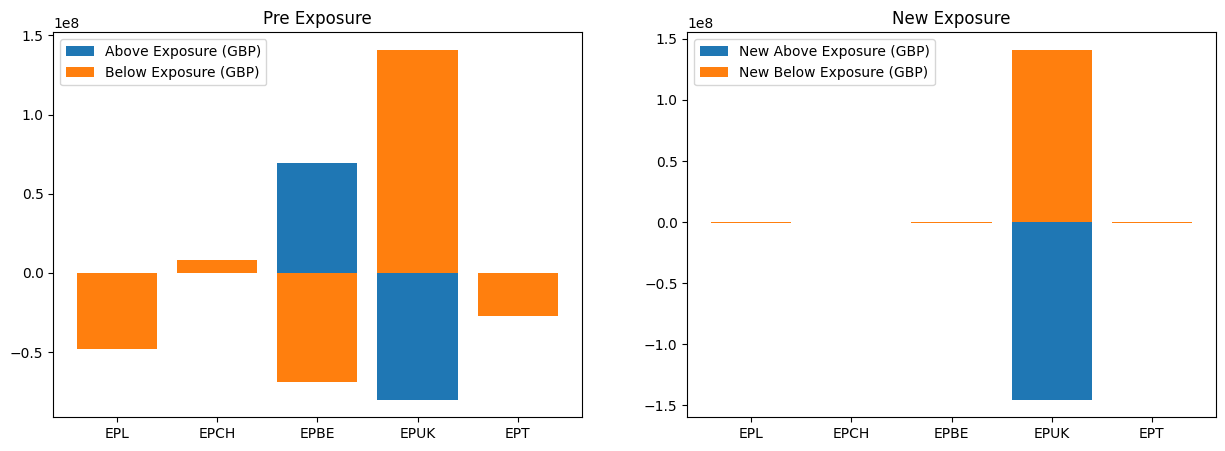

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].bar(x=exposures_entities["above_exposure_gbp"].index,height=exposures_entities["above_exposure_gbp"])
axs[0].bar(x=exposures_entities["below_exposure_gbp"].index,height=exposures_entities["below_exposure_gbp"])
axs[0].legend(["Above Exposure (GBP)","Below Exposure (GBP)"])
axs[0].set_title("Pre Exposure")

axs[1].bar(x=exposures_entities["new_above_gbp"].index,height=exposures_entities["new_above_gbp"])
axs[1].bar(x=exposures_entities["new_below_gbp"].index,height=exposures_entities["new_below_gbp"])
axs[1].legend(["New Above Exposure (GBP)","New Below Exposure (GBP)"])
axs[1].set_title("New Exposure")

Text(0.5, 1.0, 'New Exposure')

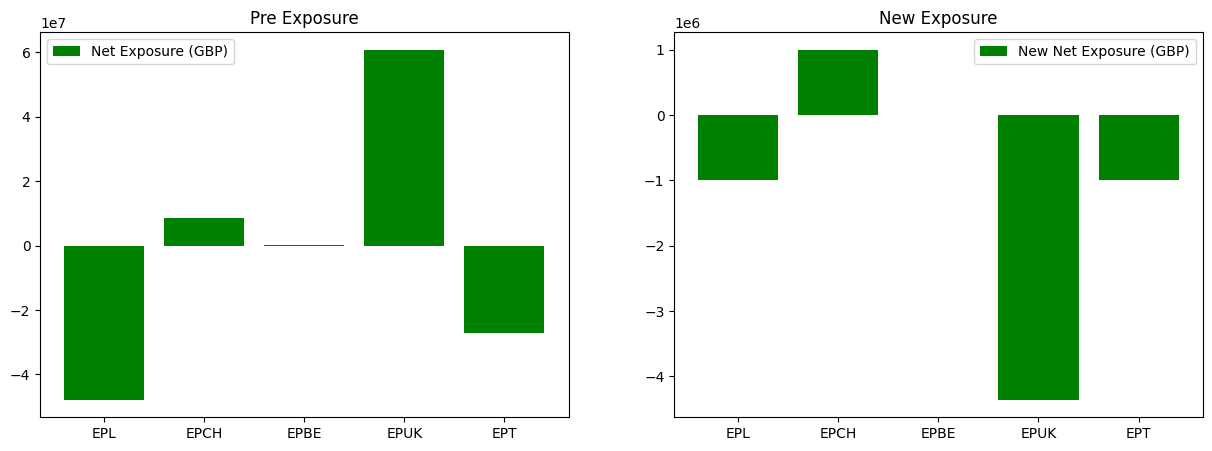

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].bar(x=exposures_entities["net_exposure_gbp"].index,height=exposures_entities["net_exposure_gbp"],color="green")
axs[0].legend(["Net Exposure (GBP)"])
axs[0].set_title("Pre Exposure")

axs[1].bar(x=exposures_entities["new_net_gbp"].index,height=exposures_entities["new_net_gbp"],color="green")
axs[1].legend(["New Net Exposure (GBP)"])
axs[1].set_title("New Exposure")

In [14]:
exposures_entities[[c for c in exposures_entities.columns if "ccy" not in c ]]

,above_exposure_gbp,below_exposure_gbp,net_exposure_gbp,new_above_gbp,new_below_gbp,new_net_gbp,internal_change_gbp,above_lhs_rhs,below_lhs_rhs,above_to_epuk_gbp,above_to_epuk_lhs_rhs
entity,,,,,,,,,,,
EPL,0.000000e+00,-4.787437e+07,-4.787437e+07,-5.000000e+05,-5.000000e+05,-1.000000e+06,4.737437e+07,LHS,RHS,4.687437e+07,RHS
EPCH,4.860163e+05,7.965067e+06,8.451084e+06,5.000000e+05,5.000000e+05,1.000000e+06,7.465067e+06,RHS,LHS,7.451084e+06,LHS
EPBE,6.923909e+07,-6.897756e+07,2.615338e+05,5.000000e+05,-5.000000e+05,0.000000e+00,6.847756e+07,LHS,RHS,2.615338e+05,LHS
EPUK,-8.015238e+07,1.409674e+08,6.081498e+07,-1.453275e+08,1.409674e+08,-4.360122e+06,0.000000e+00,NaN,NaN,0.000000e+00,NaN
EPT,0.000000e+00,-2.701334e+07,-2.701334e+07,-5.000000e+05,-5.000000e+05,-1.000000e+06,2.651334e+07,LHS,RHS,2.601334e+07,RHS


New, we net EPUK and hedge external if needed:

In [18]:
exposures_entities.loc["EPUK"].rename("EPUK_hedges").to_frame().T

,above_exposure_gbp,above_exposure_local_ccy,below_exposure_gbp,below_exposure_local_ccy,net_exposure_gbp,net_exposure_local_ccy,new_above_gbp,new_above_local_ccy,new_below_gbp,new_below_local_ccy,new_net_gbp,new_net_local_ccy,internal_change_gbp,internal_change_local_ccy,above_lhs_rhs,below_lhs_rhs,above_to_epuk_gbp,above_to_epuk_local_ccy,above_to_epuk_lhs_rhs
EPUK_hedges,-8.01524e+07,-9.38662e+07,1.40967e+08,1.65086e+08,6.0815e+07,7.12202e+07,-1.45327e+08,-1.70193e+08,1.40967e+08,1.65086e+08,-4.36012e+06,-5.10613e+06,0,0,NaN,NaN,0,0,NaN


In [21]:
[c for c in exposures_entities.columns if c not in hedges_epuk.columns]

['above_exposure_gbp',
 'above_exposure_local_ccy',
 'below_exposure_gbp',
 'below_exposure_local_ccy',
 'net_exposure_gbp',
 'net_exposure_local_ccy',
 'above_to_epuk_gbp',
 'above_to_epuk_local_ccy',
 'above_to_epuk_lhs_rhs']

In [50]:
hedges_epuk = exposures_entities.loc["EPUK"].rename("EPUK_hedges").to_frame().T.apply(
    lambda row: pd.Series(
        net_exposure(
            row.name,
            row['new_above_gbp'], 
            row['new_above_local_ccy'], 
            row['new_below_gbp'], 
            row['new_below_local_ccy'], 
            entity_threshold
        )
    ),
    axis=1
)

hedges_epuk.columns = [
    'new_above_gbp', 
    'new_above_local_ccy', 
    'new_below_gbp', 
    'new_below_local_ccy', 
    'new_net_gbp', 
    'new_net_local_ccy', 
    'internal_change_gbp', 
    'internal_change_local_ccy', 
    'above_lhs_rhs', 
    'below_lhs_rhs', 
    'above_external_gbp', 
    'above_external_local_ccy', 
    'above_external_lhs_rhs'
]

hedges_epuk.index = ["EPUK"]
hedges_epuk

,new_above_gbp,new_above_local_ccy,new_below_gbp,new_below_local_ccy,new_net_gbp,new_net_local_ccy,internal_change_gbp,internal_change_local_ccy,above_lhs_rhs,below_lhs_rhs,above_external_gbp,above_external_local_ccy,above_external_lhs_rhs
EPUK,-500000.0,-585548.663775,500000.0,585548.483687,0.0,-0.180088,1.404674e+08,1.645009e+08,RHS,LHS,4.360122e+06,5.106126e+06,RHS


In [41]:
hedges_epuk.index

Index(['EPUK'], dtype='object')

In [46]:
exposures_entities.loc["EPUK"][['above_exposure_gbp','above_exposure_local_ccy','below_exposure_gbp','below_exposure_local_ccy','net_exposure_gbp','net_exposure_local_ccy',]].to_frame().T.index

Index(['EPUK'], dtype='object')

In [49]:
pd.concat(
    [
        exposures_entities.loc["EPUK"][['above_exposure_gbp','above_exposure_local_ccy','below_exposure_gbp','below_exposure_local_ccy','net_exposure_gbp','net_exposure_local_ccy',]].to_frame().T,
        hedges_epuk[["new_above_gbp","new_above_local_ccy","new_below_gbp","new_below_local_ccy","new_net_gbp","new_net_local_ccy"]]
    ],
    axis=1
)

,above_exposure_gbp,above_exposure_local_ccy,below_exposure_gbp,below_exposure_local_ccy,net_exposure_gbp,net_exposure_local_ccy,new_above_gbp,new_above_local_ccy,new_below_gbp,new_below_local_ccy,new_net_gbp,new_net_local_ccy
EPUK,-8.01524e+07,-9.38662e+07,1.40967e+08,1.65086e+08,6.0815e+07,7.12202e+07,-500000.0,-585548.663775,500000.0,585548.483687,0.0,-0.180088


above_exposure_gbp         -8.01524e+07
above_exposure_local_ccy   -9.38662e+07
below_exposure_gbp          1.40967e+08
below_exposure_local_ccy    1.65086e+08
net_exposure_gbp             6.0815e+07
net_exposure_local_ccy      7.12202e+07
Name: EPUK, dtype: object